In [2]:
import os
import json
import copy
import pandas as pd
import math
import seaborn as sns

FAKE = {
    "mip": False,
    "has_mipgap": None,
    "mipgap": None,
    "runtime_ms": None,
    "status": None,
}


In [3]:
def flatten_dict(d, prefix):
    is_dict = isinstance(d, dict)

    newdict = dict()
    if is_dict:
        for k, v in d.items():
            nk = f"{prefix}.{k}"
            newdict[nk] = copy.deepcopy(v)
    return newdict


def flatten_list(d, prefix):
    is_list = isinstance(d, list)

    newdict = dict()
    if is_list:
        r = []
        for i, v in enumerate(d):
            nk = f"{prefix}[{i}]"
            r.append(flatten_dict(v, nk))
        for dic in r:
            newdict = newdict | dic

    return newdict


In [4]:
FOLDER = "./results"
PREFIX = "esvis-ds"

folders_with_call_file = []

for subdir, dirs, files in os.walk(FOLDER):
    if "call.json" in files and subdir.startswith(os.path.join(FOLDER, PREFIX)):
        folders_with_call_file.append(subdir)

calls = []
for dir in folders_with_call_file:
    callfile = os.path.join(dir, "call.json")
    with open(callfile, "r") as f:
        call = json.load(f)
        call = call | flatten_dict(call["ctx"], "ctx")
        del call["ctx"]
        if "metrics" in call:
            call = call | flatten_list(call["metrics"], "metrics")
            del call["metrics"]

        # also merge the embedding metrics
        embedding_metrics = None
        with open(os.path.join(dir, 'metrics_embedding.json')) as f:
            embedding_metrics = json.load(f)
            call = call | embedding_metrics[0]

        # merge also the additional files
        for ilp_status_file in ["connect", "overlapremoval", "route", 'layout']:
            filename = f"ilp_status_{ilp_status_file}_0.json"
            filepath = os.path.join(dir, filename)
            status_file_exists = os.path.exists(filepath)
            if status_file_exists:
                with open(filepath, "r") as f:
                    status_file_data = flatten_dict(
                        json.load(f), f"ilp_{ilp_status_file}"
                    )
                    call = call | status_file_data
            else:
                call = call | FAKE
        calls.append(call)

df = pd.DataFrame(data=calls)


In [30]:
# post process

df["success"] = df.success.astype("bool")
df['dataset'] = df['ctx.general.dataset'].astype(str).map(lambda s:s[ s.index('_') + 1 : s.index('_') + 1 + s[s.index('_') + 1:].index('_')])
df['duration_s'] = df['duration_ms'].astype(float).map(lambda d: d / 1000)
df['duration_m'] = df['duration_s'].astype(float).map(lambda d: d / 60)



<Axes: xlabel='dataset', ylabel='ctx.layout.overlapremover-ctx.connect.connecter-ctx.route.router'>

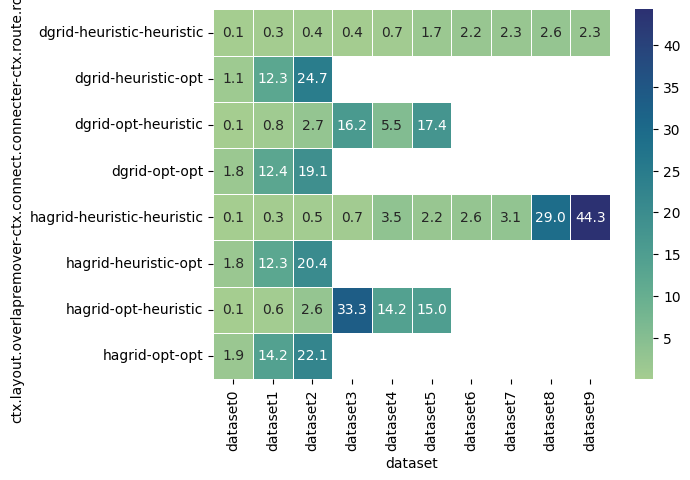

In [37]:
import matplotlib.pyplot as plt

weight = 0.5
good_runs = df[(df["success"] == True) & (df["ctx.general.weight"] == weight)]
sns.heatmap(
    good_runs.pivot_table(
        index=[
            "ctx.layout.overlapremover",
            "ctx.connect.connecter",
            "ctx.route.router",
        ],
        columns=["dataset"],
        values="duration_m",
        aggfunc='median',
    ),
    linewidth=0.5,
    annot=True,
    fmt=".1f",
    cmap="crest",
)
